# Classification

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

## Data Preperation

In [2]:
import sys
sys.path.append('../../data')
from corpus import load_corpus
data = load_corpus('weebit')

X_train = data['X_train']
y_train = data['y_train']
y_train_onehot = data['y_train_onehot']
X_test = data['X_test']
y_test = data['y_test']
y_test_onehot = data['y_test_onehot']

Using TensorFlow backend.


## Classical ML

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


def train_classification_model(model_class, X_train, y_train, model_params={}, hyperparameters_grid={}):
    
    name = model_class.__name__
    
    if 'kernel' in model_params:
        name += ' ' + model_params['kernel']
    
    model = model_class(random_state=42, **model_params)
    if hyperparameters_grid:
        model = GridSearchCV(model, hyperparameters_grid)
        
    model.fit(X_train, y_train)
        
    return name, model


Cs = 10.**np.arange(-4, 5)
    
models = dict([train_classification_model(model_class, X_train, y_train, model_params, hyperparameters_grid)
          for model_class, model_params, hyperparameters_grid in
                                     tqdm([
                                         (LogisticRegressionCV, {},  {}),
                                         (LinearSVC, {}, {'C': Cs}),
                                         (SVC, {'kernel': 'rbf', 'probability': True}, {'C': Cs}),
                                         (SVC, {'kernel': 'poly', 'probability': True}, {'C': Cs}),
                                         (SVC, {'kernel': 'sigmoid', 'probability': True}, {'C': Cs}),
                                         (RandomForestClassifier, {}, {'n_estimators': range(10, 101, 10),
                                                                  'max_features': ['auto', 'sqrt'],
                                                                  'max_depth': range(10, 101, 10)}),
                                        (GradientBoostingClassifier, {}, {}),
                                     ])])

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:57<00:00, 76.75s/it]


## MLP

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

n_features = X_train.shape[1]

def train_mlp(units):
    model = Sequential()
    model.add(Dense(units, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train_onehot, epochs=30, verbose=0)#, validation_split=0.1,)
    
    return model


models['MLP 16'] = train_mlp(16)
models['MLP 32'] = train_mlp(32)
models['MLP 64'] = train_mlp(64)
models['MLP 128'] = train_mlp(128)

In [5]:
deep_model = Sequential()
deep_model.add(Dense(256, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
deep_model.add(Dense(5, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

deep_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

deep_model.fit(X_train, y_train_onehot, epochs=100, verbose=0)

models['MLP-deep'] = deep_model

## Evaluation

In [6]:
import itertools
import functools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

def predict_classes(model, X_test):
    if hasattr(model, 'predict_classes'):
        y_pred = model.predict_classes(X_test)
    else:
        y_pred = model.predict(X_test)

    return y_pred
    
def calc_metrics(model, X_test, y_test):
    y_pred = predict_classes(model, X_test)
    
    return {metrics.__name__: metrics(y_test, y_pred) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]}

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

In [7]:
summary_evaluation_df = evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre']].astype(float).round(4)
summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre
MLP-deep,0.6868,0.6868,0.9327
GradientBoostingClassifier,0.7102,0.7102,0.9258
MLP 16,0.6896,0.6896,0.9245
MLP 32,0.6882,0.6882,0.9231
SVC rbf,0.7088,0.7088,0.9217
SVC poly,0.6799,0.6799,0.9203
LogisticRegressionCV,0.6854,0.6854,0.9162
LinearSVC,0.6772,0.6772,0.9148
MLP 128,0.6896,0.6896,0.9148
MLP 64,0.6868,0.6868,0.9135


In [8]:
summary_evaluation_df.to_excel('classification_evaluation.xlsx')

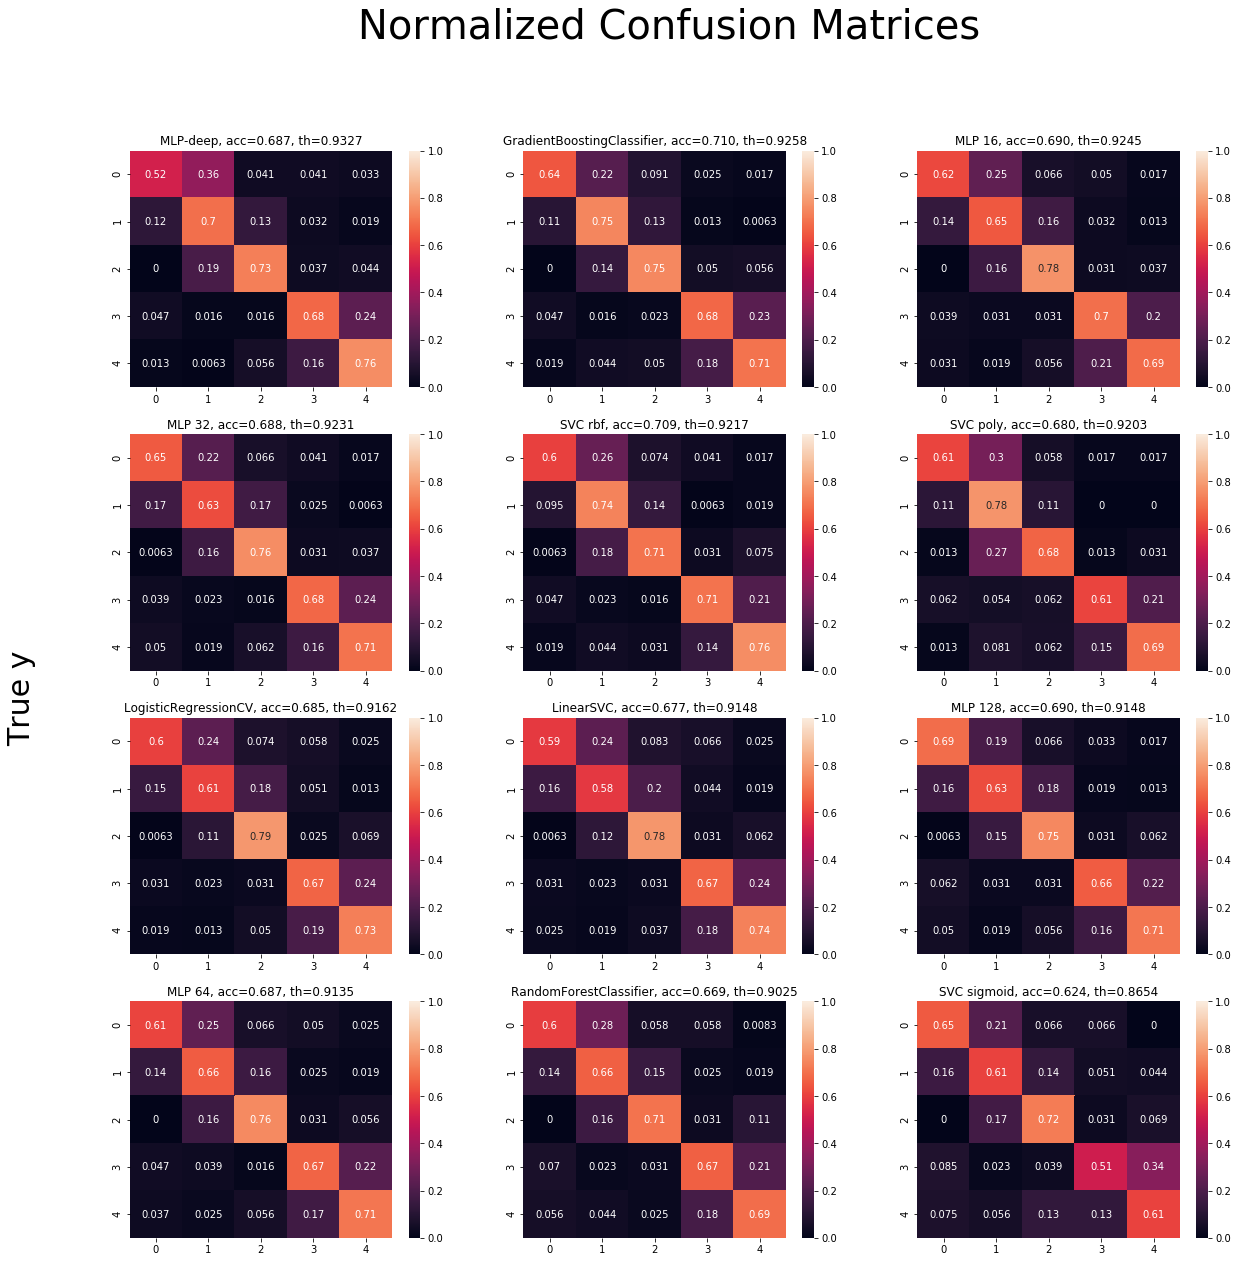

In [9]:
f, axes = plt.subplots(4, 3, figsize=(20, 20))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):
    cm = r['confusion_matrix']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, annot=True,
                ax=ax)
    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))

f.text(0.04, 0.5, 'True y', va='center', rotation='vertical', fontsize=30)
f.suptitle('Normalized Confusion Matrices', fontsize=40);

### Probs Analysis

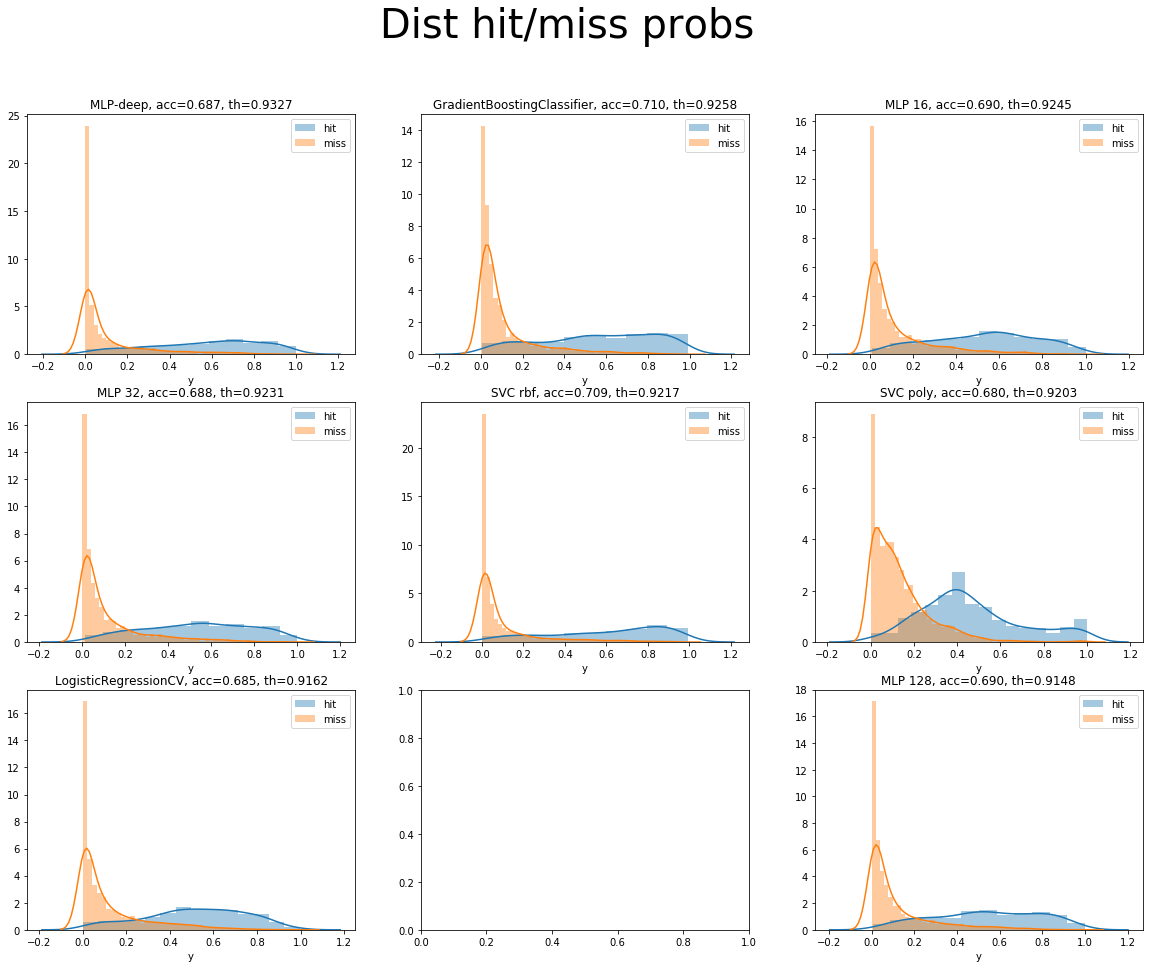

In [10]:
f, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):

    model = models[name]
    try:
        y_pred_probs = model.predict_proba(X_test)
    except AttributeError:
        continue
    
    assert np.allclose(y_pred_probs.sum(axis=1), 1)
    
    sns.distplot(np.choose(y_test, y_pred_probs.T), label='hit', ax=ax)


    sns.distplot(np.array([[prob for index, prob in enumerate(probs) 
                      if cls != index ]
                 for probs, cls in  zip(y_pred_probs, y_test)]).flatten(),
             label='miss', ax=ax)

    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))
    ax.legend()
    
for ax in axes:
    ax.set_visible(False)
    
f.suptitle('Dist hit/miss probs', fontsize=40);

### Average y as Regression

In [11]:
import itertools
import functools
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score,\
                            classification_report, accuracy_score, confusion_matrix, f1_score


def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')

   
def calc_metrics(model, X_test, y_test):
    y_pred_probs = model.predict_proba(X_test)
    y_pred_avg = (y_pred_probs * np.arange(5)).sum(axis=1)
    y_pred_avg_classes = y_pred_avg.round().clip(0, 4).astype(int)

    metrics = {}

    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg) for metrics in [mean_absolute_error,
                                                                      mean_squared_error,
                                                                      explained_variance_score,                                                                      explained_variance_score,
                                                                      r2_score
                                                                      
    ]})
    
    metrics.update({metrics.__name__: metrics(y_test, y_pred_avg_classes) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]})

    return metrics

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()
                             if name not in ['LinearSVC', 'SVC']}).transpose()
evaluation_df = evaluation_df.sort_values('threshold_socre', ascending=False)

In [12]:
summary_evaluation_df = (evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre', 'mean_squared_error', 'mean_absolute_error', 'explained_variance_score', 'r2_score']]
     .astype(float).round(4))
summary_evaluation_df

,accuracy_score,f1_score_micro,threshold_socre,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
MLP-deep,0.6484,0.6484,0.9437,0.5122,0.4923,0.7362,0.7351
SVC rbf,0.6415,0.6415,0.9423,0.5233,0.4904,0.7296,0.7294
MLP 32,0.6030,0.6030,0.9382,0.5815,0.5436,0.6993,0.6993
MLP 64,0.5893,0.5893,0.9368,0.5772,0.5420,0.7017,0.7015
MLP 128,0.6154,0.6154,0.9299,0.5858,0.5348,0.6972,0.6970
MLP 16,0.5742,0.5742,0.9299,0.5930,0.5548,0.6936,0.6933
GradientBoostingClassifier,0.5810,0.5810,0.9217,0.6152,0.5595,0.6819,0.6819
LogisticRegressionCV,0.5591,0.5591,0.9217,0.6321,0.5889,0.6734,0.6731
SVC poly,0.5014,0.5014,0.9025,0.7088,0.6284,0.6335,0.6335
RandomForestClassifier,0.4245,0.4245,0.8887,0.8569,0.7257,0.5569,0.5569


In [13]:
summary_evaluation_df.to_excel('probs_avg_classification_evaluation.xlsx')